In [37]:
import os

import numpy as np
import pandas as pd
from scipy.stats import median_absolute_deviation
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn import preprocessing
random_state = 1234

In [2]:
from sklearn.preprocessing import StandardScaler
import random

In [3]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

In [4]:
import optuna

In [5]:
data_dir = r"D:\NIH\Mutational-Spectrum-master\Data\New\Unlabeled"

In [6]:
def list_files_in_dir(dirname):
    dir_files = list()
    for root, _, files in os.walk(dirname):
        for file in files:
            dir_files.append(os.path.join(root, file))
    
    return dir_files

# Add dropout layer right after the input layer to autoencoder

In [7]:
class Autoencoder(Model):
    def __init__(self, input_shape, latent_dim, num_nodes, num_layers):
        super(Autoencoder, self).__init__()
        if num_layers > num_nodes:
          num_layers = num_nodes
        self.latent_dim = latent_dim   
        self.encoder = self.createEncoder(num_nodes, num_layers)
        self.decoder = self.createDecoder(num_nodes, num_layers)

    def createEncoder(self, num_nodes, num_layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(num_nodes, activation = 'relu', input_shape=(96,)))
        # Dropout Layer
        units = [int(num_nodes/(2**i)) for i in range(1, num_layers)]
        for unit in range(len(units)):
            model.add(tf.keras.layers.Dense(units[unit], activation = 'relu'))
        model.add(tf.keras.layers.Dense(self.latent_dim, activation = 'relu'))    
        return model
    
    def createDecoder(self, num_nodes, num_layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(num_nodes/(2**(num_layers-1)), activation = 'relu', input_shape=(self.latent_dim,)))
        
        units = [int(num_nodes/(2**i)) for i in range(0, num_layers-1)]
        for unit in reversed(range(len(units))):
            model.add(tf.keras.layers.Dense(units[unit], activation = 'relu'))   
        model.add(tf.keras.layers.Dense(96, activation = 'relu'))
        return model

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [8]:
def build_mlp_model(input_shape, latent_dim, num_nodes, num_layers, learning_rate):
    
    autoencoder = Autoencoder(input_shape, latent_dim, num_nodes, num_layers)  
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=opt, loss="mse")
   
    return autoencoder

In [9]:
def get_row_indices_with_sum_zero(X):
    return X.index[(X.sum(axis=1) == 0)].tolist()

In [40]:
# Z-score normalization
def scale_row(X):
    for column in X.columns:
        X[column] = (X[column] -
                               X[column].mean()) / X[column].std() 
    return X

In [35]:
def dataset_generator(data_dir, num_files):

    # Would take eons to run if I didn't limit this to only the first file  
    for datafile in random.sample(list_files_in_dir(data_dir), num_files):
        data = pd.read_csv(datafile)
        X = data.iloc[:, :96]
        y = (data['is_sig3']).astype(np.int_)
#         X.columns = X.columns.str.replace('[', '').str.replace(']', '').str.replace('>', '')
        X = scale_row(X)
    yield X, y

In [12]:
def scale_data(df):
    # Define the scaler 
    scaler = StandardScaler().fit(df)
    # Scales each individual row   
    df[df.columns] = scaler.fit_transform(df[df.columns])
    
    directory = 'C:/Users/AaronGe/Documents/NCI/Mutational Signature Classification/Mutational-Spectrum/mean_var/'
    
#     Save mean and variance into a directory
#     np.savez(directory + file_name + '.npz', mean=scaler.mean_, var=scaler.var_)
    return df
    

In [20]:
def train_val_test_generator(data_dir, num_samples, test_frac=0.1):
    val_frac = test_frac/(1.0 - test_frac)
    
    for X, y in dataset_generator(data_dir, num_samples):
        fold_data = list()
        skf = StratifiedKFold(n_splits=5)
        print(X)
        for train_val_index, test_index in skf.split(X, y):
            X_test, y_test = X.iloc[test_index, :], y.iloc[test_index]
            X_train, X_val, y_train, y_val = train_test_split(
                X.iloc[train_val_index,:], y.iloc[train_val_index], 
                test_size=val_frac, 
                random_state=random_state, 
                stratify=y.iloc[train_val_index]
            )
            #X_train, X_val, X_test = scale_columns(X_train, X_val, X_test)
            fold_data.append(((X_train, y_train), 
                              (X_val, y_val), 
                              (X_test, y_test)))
        yield fold_data

In [14]:
def compute_mlp_performance(trial, data_dir=data_dir, n_folds=10, input_shape=(96,), latent_dim=3,
                            num_nodes=5, num_layers=3, 
                            learning_rate=0.001, num_samples = 1):
    aucs = list()
    models = list()
    
    # 60-20-20 split
    test_frac=1.0/float(n_folds)
#     fpr_list = []
#     tpr_list = []
#     roc_auc_list = []
    
    for folds_data in train_val_test_generator(data_dir, num_samples=num_samples, test_frac=test_frac):
        fold_aucs = list()
        fold_models = list()
        
        for fold_data in folds_data:
            # get data
            (X_train, y_train), (X_val, y_val), (X_test, y_test) = fold_data
            # build model and ensure that parameters passed in are within the normal range
            # if we don't type cast as integers, bayesian optimizer will guess float values
            model = build_mlp_model(input_shape, 
                                    trial.suggest_int('latent_dim', 1, 40), 
                                    2**int(trial.suggest_int('num_nodes', 1, 8)), 
                                    trial.suggest_int('num_layers', 1, 5), 
                                    trial.suggest_float('learning_rate', 1e-6, 1e-1)
                                    )
            history = model.fit(X_train, X_train, 
                      validation_data=(X_val, X_val), 
                      epochs=1000, batch_size=32, verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
            
            # evaluate
            y_score = model.evaluate(X_test, X_test, verbose=0)
            fold_aucs.append(y_score)
            fold_models.append(model)
        aucs.append(fold_aucs)
        models.append(fold_models)
        
    # Gets median index value for all the different samples (rows)  
    medianIndices = [indices[len(aucs[0])//2] for indices in np.argsort(aucs, axis=1)]
    medianValues = [values[index] for values, index in zip(aucs, medianIndices)]
    
    # Gets the file which contains the median of median value
    fileInd = np.argsort(medianValues)[len(medianValues)//2]
    
    aucs = np.array(aucs)
    
    median_of_median_model = models[fileInd][medianIndices[fileInd]]
    median_of_median_auc = np.median(np.median(aucs, axis=1))
    mad_of_mad_auc = median_absolute_deviation(median_absolute_deviation(aucs, axis=1))
#     return median_of_median_model, median_of_median_auc
    return median_of_median_auc



In [17]:
def compute_mlp_performance(trial, data_dir=data_dir, n_folds=10, input_shape=(96,), latent_dim=3,
                            num_nodes=5, num_layers=3, 
                            learning_rate=0.001, num_samples = 1):
    aucs = list()
    models = list()
  
    for x,y in dataset_generator(data_dir, 1):
        # build model and ensure that parameters passed in are within the normal range
        # if we don't type cast as integers, bayesian optimizer will guess float values
        model = build_mlp_model(input_shape, 
                        trial.suggest_int('latent_dim', 1, 40), 
                        2**int(trial.suggest_int('num_nodes', 1, 10)), 
                        trial.suggest_int('num_layers', 1, 7), 
                        trial.suggest_float('learning_rate', 1e-8, 3e-1))
        history = model.fit(x, x, 
                  epochs=1000, batch_size=32, verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=20)])

#         return history
        # evaluate
        y_score = model.evaluate(x, x, verbose=0)
        aucs.append(y_score)
        models.append(model)
            
#     return aucs[0], models[0]
    return aucs[0]




Final result: {'target': -0.011544853448867798, 'params': {'latent_dim': 15.819540354257267, 'learning_rate': 0.0002798666792298152, 'num_layers': 1.5529285102861934, 'num_nodes': 5.009360887675096}}

# Average MSE if I predicted a 0 Vector each time is 0.0705. After optimization, the MSE achieved by the autoencoder is 0.0115


In [ ]:
y_pred = x_test[0]
y_pred[y_pred!=0] = 0

MSEs = []
for patient in x_test: 
    MSE = np.square(np.subtract(patient,y_pred)).mean()
    MSEs.append(MSE)
np.average(MSEs)

In [62]:
model.encoder.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 32)                3104      
                                                                 
 dense_41 (Dense)            (None, 15)                495       
                                                                 
Total params: 3,599
Trainable params: 3,599
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.decoder.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 32)                512       
                                                                 
 dense_43 (Dense)            (None, 96)                3168      
                                                                 
Total params: 3,680
Trainable params: 3,680
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.decoder.save('MSKIMPACT_decoder.h5')

In [22]:
model.encoder.save('MSKIMPACT_encoder.h5')

In [30]:
data_dir = r"D:\NIH\Mutational-Spectrum-master\Data\New\Unlabeled"
for x,y in dataset_generator(data_dir, 1):
  x_test = np.array(x)



      A[C>A]A   A[C>A]C   A[C>A]G   A[C>A]T   A[C>G]A   A[C>G]C   A[C>G]G  \
0   -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
1   -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
2   -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
3   -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
4   -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
..        ...       ...       ...       ...       ...       ...       ...   
859 -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
860 -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
861 -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
862 -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   
863 -0.169548 -0.234404 -0.113559 -0.118678 -0.123597 -0.153937 -0.118678   

      A[C>G]T   A[C>T]A   A[C>T]C  ...   T[T>A]G   T[T>A]T   T[T>C]A  \
0  

In [27]:
# Average number of mutations per patient in the unlabeled dataset
np.average(x_test.sum(axis=1))

4.166666666666667

In [28]:
model.evaluate(x_test,x_test)

27/27 [==============================] - 0s 959us/step - loss: 0.0127


0.012738610617816448

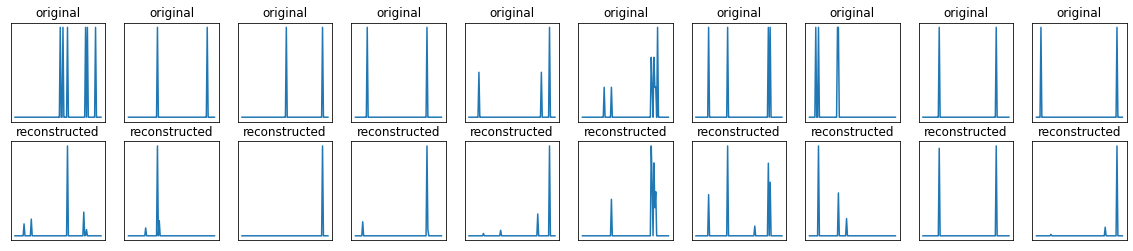

In [29]:
# Now testing it on nature dataset
nature_dataset=r"D:\NIH\Mutational-Spectrum-master\Data\New\MSK_Impact_train"
for x,y in dataset_generator(nature_dataset, 1):
  x_test = np.array(x)

encoded_imgs = model.encoder(x_test).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.plot(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
# Average number of mutations per patient in the labeled dataset
np.average(x_test.sum(axis=1))

3.247191011235955

In [31]:
model.evaluate(x_test,x_test)

20/20 [==============================] - 0s 1ms/step - loss: 0.0159


0.01589665561914444

# Optuna Optimization

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(compute_mlp_performance, n_trials=50)

[I 2022-06-21 12:38:30,334] A new study created in memory with name: no-name-a7ac5c8e-82eb-4844-bc69-df38df5e3b6a
[I 2022-06-21 12:38:53,972] Trial 0 finished with value: 0.9695504307746887 and parameters: {'latent_dim': 20, 'num_nodes': 1, 'num_layers': 5, 'learning_rate': 0.0013160407389554926}. Best is trial 0 with value: 0.9695504307746887.
[I 2022-06-21 12:38:55,858] Trial 1 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 38, 'num_nodes': 9, 'num_layers': 4, 'learning_rate': 0.040556999707947926}. Best is trial 0 with value: 0.9695504307746887.
[I 2022-06-21 12:38:57,579] Trial 2 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 10, 'num_nodes': 1, 'num_layers': 5, 'learning_rate': 0.2860991275099694}. Best is trial 0 with value: 0.9695504307746887.
[I 2022-06-21 12:38:59,478] Trial 3 finished with value: 0.989723265171051 and parameters: {'latent_dim': 37, 'num_nodes': 7, 'num_layers': 2, 'learning_rate': 0.02034902007109017}. Best is t

[I 2022-06-21 12:40:15,476] Trial 33 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 37, 'num_nodes': 2, 'num_layers': 2, 'learning_rate': 0.04608176008024176}. Best is trial 24 with value: 0.4301240146160126.
[I 2022-06-21 12:40:43,743] Trial 34 finished with value: 0.37179237604141235 and parameters: {'latent_dim': 32, 'num_nodes': 4, 'num_layers': 1, 'learning_rate': 0.00021011989768485542}. Best is trial 34 with value: 0.37179237604141235.
[I 2022-06-21 12:40:45,556] Trial 35 finished with value: 0.961222231388092 and parameters: {'latent_dim': 32, 'num_nodes': 4, 'num_layers': 1, 'learning_rate': 0.03536105595542941}. Best is trial 34 with value: 0.37179237604141235.
[I 2022-06-21 12:40:48,930] Trial 36 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 28, 'num_nodes': 9, 'num_layers': 4, 'learning_rate': 0.06601319474217805}. Best is trial 34 with value: 0.37179237604141235.
[I 2022-06-21 12:40:52,400] Trial 37 finished with value: 0.89

In [42]:
study.optimize(compute_mlp_performance, n_trials=100)

[I 2022-06-21 12:41:58,785] Trial 50 finished with value: 0.8831408023834229 and parameters: {'latent_dim': 36, 'num_nodes': 5, 'num_layers': 2, 'learning_rate': 0.012431503248654106}. Best is trial 34 with value: 0.37179237604141235.
[I 2022-06-21 12:42:27,625] Trial 51 finished with value: 0.9512526988983154 and parameters: {'latent_dim': 39, 'num_nodes': 3, 'num_layers': 3, 'learning_rate': 0.0005514630246325506}. Best is trial 34 with value: 0.37179237604141235.
[I 2022-06-21 12:42:31,132] Trial 52 finished with value: 0.9016300439834595 and parameters: {'latent_dim': 40, 'num_nodes': 3, 'num_layers': 2, 'learning_rate': 0.010268899399092762}. Best is trial 34 with value: 0.37179237604141235.
[I 2022-06-21 12:42:32,159] Trial 53 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 35, 'num_nodes': 8, 'num_layers': 1, 'learning_rate': 0.044942752765982814}. Best is trial 34 with value: 0.37179237604141235.
[I 2022-06-21 12:42:33,673] Trial 54 finished with value: 0

[I 2022-06-21 12:44:20,442] Trial 84 finished with value: 0.4170624315738678 and parameters: {'latent_dim': 30, 'num_nodes': 4, 'num_layers': 1, 'learning_rate': 0.0015021211625385212}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:44:21,971] Trial 85 finished with value: 0.916535496711731 and parameters: {'latent_dim': 25, 'num_nodes': 5, 'num_layers': 1, 'learning_rate': 0.024384926342250726}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:44:24,875] Trial 86 finished with value: 0.6615452170372009 and parameters: {'latent_dim': 29, 'num_nodes': 4, 'num_layers': 1, 'learning_rate': 0.012166842347906949}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:44:25,964] Trial 87 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 32, 'num_nodes': 6, 'num_layers': 1, 'learning_rate': 0.04168520108311927}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:44:27,452] Trial 88 finished with value: 0.99884

[I 2022-06-21 12:48:48,392] Trial 118 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 33, 'num_nodes': 6, 'num_layers': 1, 'learning_rate': 0.14743253299086131}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:48:50,263] Trial 119 finished with value: 0.9988425970077515 and parameters: {'latent_dim': 8, 'num_nodes': 5, 'num_layers': 5, 'learning_rate': 0.09111016067808425}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:48:51,658] Trial 120 finished with value: 0.9874500632286072 and parameters: {'latent_dim': 30, 'num_nodes': 6, 'num_layers': 1, 'learning_rate': 0.030617389054155557}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:48:55,553] Trial 121 finished with value: 0.6550441384315491 and parameters: {'latent_dim': 25, 'num_nodes': 4, 'num_layers': 1, 'learning_rate': 0.007079782946709411}. Best is trial 76 with value: 0.3331867456436157.
[I 2022-06-21 12:48:58,578] Trial 122 finished with value: 0.61

In [43]:
study.best_trial

FrozenTrial(number=76, values=[0.3331867456436157], datetime_start=datetime.datetime(2022, 6, 21, 12, 43, 44, 845845), datetime_complete=datetime.datetime(2022, 6, 21, 12, 43, 58, 561653), params={'latent_dim': 27, 'num_nodes': 5, 'num_layers': 1, 'learning_rate': 0.0003544192232908549}, distributions={'latent_dim': IntUniformDistribution(high=40, low=1, step=1), 'num_nodes': IntUniformDistribution(high=10, low=1, step=1), 'num_layers': IntUniformDistribution(high=7, low=1, step=1), 'learning_rate': UniformDistribution(high=0.3, low=1e-08)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=76, state=TrialState.COMPLETE, value=None)